# Move recommendations

In [13]:
import json
import subprocess
import sys

import chess.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [14]:
df = pd.read_parquet('data/moves_2025_01.parquet')
df.tail()

,avg_elo,moves,winner
4990819,1553.0,e2e4 d7d5 e4d5 d8d5 b1c3 d5e6 f1e2 b8c6 g1f3 g...,1
4990836,1960.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 c1e3 c8g4 f1e2 b...,1
4990890,817.5,e2e4 d7d5 e4d5 d8d5 d2d3 d5d4 c2c3 d4e5 f1e2 c...,2
4991060,1251.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 b1c3 g7g6 c3d5 f...,1
4991095,1889.5,e2e4 d7d5 e4d5 d8d5 g1f3 c8g4 f1e2 b8c6 e1g1 e...,1


In [15]:
def get_fen_after_n_moves(moves_str, n_moves=8):
    b = chess.Board()
    for mv in moves_str.split()[:n_moves]:
        b.push_uci(mv)
    return b.fen()


df["fen"] = df["moves"].apply(lambda x: get_fen_after_n_moves(x, 8))
df["next_move"] = df["moves"].apply(lambda x: x.split()[8] if len(x.split()) > 8 else None)
df_filtered = df.dropna(subset=["next_move"])
df_fen = df.copy()

df_positions = (
    df_filtered
    .groupby("fen")
    .agg(
        count=("next_move", "size"),
        white_wins=("winner", lambda x: (x == 1).sum())
    )
)

df_positions = df_positions.sort_values(by="count", ascending=False).reset_index()
df_positions.head()

,fen,count,white_wins
0,rnb1kbnr/ppp1pppp/8/8/8/2N5/PPPPqPPP/R1B1KBNR ...,2696,1267
1,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,2650,1259
2,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N5/PPPPBPPP/R1BQK...,2116,1126
3,rnb1kbnr/ppp1pppp/6q1/8/8/2N5/PPPPBPPP/R1BQK1N...,1772,822
4,rnb1kb1r/ppp1pppp/4qn2/8/8/2N5/PPPPBPPP/R1BQK1...,1253,686


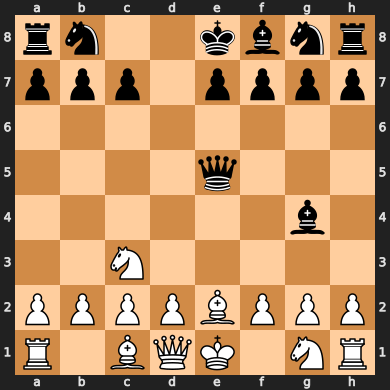

In [16]:
sample_game = df_positions.iloc[1]
chess.Board(sample_game["fen"])

In [17]:
print(f"Total games from this position: {sample_game["count"]}")
print(f"Win rate for White: {(sample_game["white_wins"] / sample_game["count"]):.2%}")

Total games from this position: 2650
Win rate for White: 47.51%


In [18]:
df_next_move = (
    df_filtered
    .groupby(["fen", "next_move"])
    .agg(
        avg_elo_mean=("avg_elo", lambda x: int(x.mean())),
        count=("next_move", "size"),
        white_wins=("winner", lambda x: (x == 1).sum())
    )
    .reset_index()
)

df_next_move = df_next_move[df_next_move["fen"] == sample_game["fen"]]
df_next_move = df_next_move[df_next_move["count"] > 10]
df_next_move

,fen,next_move,avg_elo_mean,count,white_wins
2677,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d3,1591,114,54
2678,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d4,1680,726,374
2680,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f3,1503,720,351
2682,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1f3,1507,816,350
2684,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,h2h3,1516,255,120


In [19]:
proc_ep = subprocess.run(
    [sys.executable, 'engine_play.py', sample_game["fen"]],
    capture_output=True,
    text=True
)

if proc_ep.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc_ep.stderr}")

engine_move = proc_ep.stdout
print(f"Best move recommended by the engine: {engine_move}")

Best move recommended by the engine: d2d4



In [31]:
fen = sample_game["fen"]
moves = str(df_next_move["next_move"].tolist())

proc = subprocess.run(
    [sys.executable, 'evaluate_engine_variance.py', fen, moves],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc.stderr}")

engine_results = json.loads(proc.stdout)
engine_df = pd.DataFrame(engine_results)

df_stats = df_next_move.merge(engine_df, on='next_move')
df_stats

,fen,next_move,avg_elo_mean,count,white_wins,delta,complexity,variance_mean
0,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d3,1591,114,54,-83,0.262315,2436.834934
1,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d4,1680,726,374,4,0.543103,28089.136717
2,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f3,1503,720,351,-37,0.231527,829.786008
3,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1f3,1507,816,350,-149,0.467980,26142.478281
4,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,h2h3,1516,255,120,-75,0.384236,7444.571559


## Calculate score for the elo based recommendation
based on
* complexity: fragility score calculated in 'evaluate_engine.py' and contained in above table
* rating: delta of centipawn score for the next move (also contained in df_stats)
* winrate of historical games played by players with a similar elo: has to be done for each elo level we want to analyze

In [21]:
min_elo = int(df["avg_elo"].min())
max_elo = int(df["avg_elo"].max())
# sample_elos = random.sample(range(min_elo, max_elo + 1), 5)
sample_elos = [352, 630, 1102, 1590, 1923, 2332]
df_fen_filtered = df_fen[df_fen["fen"] == sample_game["fen"]]

ELO_DEVIATION = 500
COMPLEXITY_WEIGHT_MAX = 0.3  # dynamic
RATING_WEIGHT = 0.3

In [22]:
def analyze_moves(data_stats, data_fen, e):
    for mv in data_stats["next_move"].tolist():
        low = e - ELO_DEVIATION
        high = e + ELO_DEVIATION
        data_filtered = data_fen[(data_fen['avg_elo'].between(low, high)) & (data_fen["next_move"] == mv)]
        data_stats["winrate_" + str(elo)] = (
            (data_filtered["winner"] == 1).mean() if len(data_filtered) > 0 else 0.0
        )

    factor = max(0.0, (elo - 1000) / 1000)
    complexity_weight = max(0.0, COMPLEXITY_WEIGHT_MAX * (1 - factor))
    rating_weight = RATING_WEIGHT
    winrate_weight = 1 - complexity_weight - rating_weight

    scaler = MinMaxScaler()
    data_stats[['rating_scaled', 'complexity_scaled', 'winrate_scaled']] = scaler.fit_transform(
        data_stats[['delta', 'complexity', "winrate_" + str(elo)]]
    )
    data_stats['complexity_scaled'] = 1 - data_stats['complexity_scaled']

    data_stats["score_" + str(elo)] = (
            rating_weight * data_stats['rating_scaled'] +
            complexity_weight * data_stats['complexity_scaled'] +
            winrate_weight * data_stats['winrate_scaled']
    )

    best_mv = data_stats.sort_values("score_" + str(elo), ascending=False)["next_move"].iloc[0]
    return data_stats, best_mv


for elo in sorted(sample_elos):
    df_stats, best_move = analyze_moves(df_stats, df_fen_filtered, elo)
    print(f"Recommended move at Elo {elo}:\t{best_move}")

Recommended move at Elo 352:	f2f3
Recommended move at Elo 630:	f2f3
Recommended move at Elo 1102:	f2f3
Recommended move at Elo 1590:	f2f3
Recommended move at Elo 1923:	d2d4
Recommended move at Elo 2332:	d2d4


In [23]:
df_stats["winrate_total"] = df_stats["white_wins"] / df_stats["count"]
df_result = df_stats[
    ["next_move", "delta", "complexity", "winrate_total"] +
    [col for col in df_stats.columns if col.startswith("score_")]
    ]
df_result

,next_move,delta,complexity,winrate_total,score_352,score_630,score_1102,score_1590,score_1923,score_2332
0,d2d3,-99,0.262315,0.473684,0.386018,0.386018,0.358442,0.226509,0.136480,0.115663
1,d2d4,3,0.543103,0.515152,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000
2,f2f3,-43,0.231527,0.487500,0.516867,0.516867,0.486267,0.339867,0.239967,0.216867
3,g1f3,-163,0.467980,0.428922,0.072332,0.072332,0.064954,0.029656,0.005570,0.000000
4,h2h3,-73,0.384236,0.470588,0.315615,0.315615,0.300013,0.225366,0.174429,0.162651


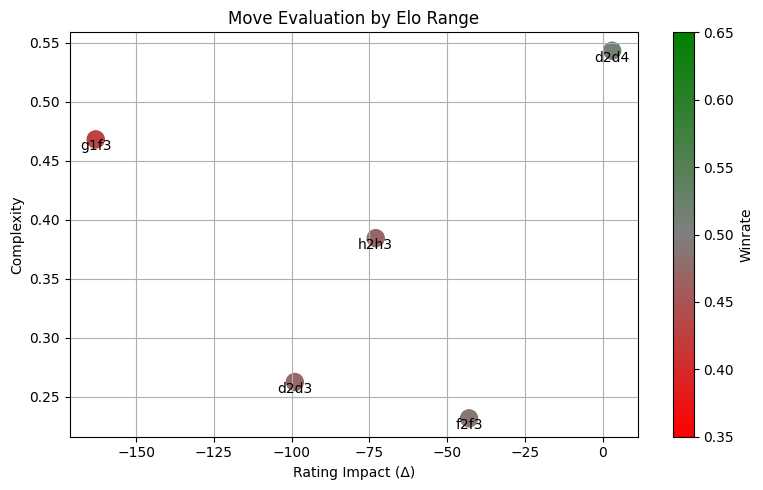

In [24]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("RG", ["red", "gray", "green"])
norm = mpl.colors.Normalize(vmin=0.35, vmax=0.65)

plt.figure(figsize=(8, 5))
sc = plt.scatter(
    df_result['delta'],
    df_result['complexity'],
    c=df_result['winrate_total'],
    cmap=cmap,
    norm=norm,
    s=150
)

for _, row in df_result.iterrows():
    plt.text(
        row['delta'],
        row['complexity'],
        row['next_move'],
        fontsize=10,
        ha='center',
        va='top'
    )

plt.colorbar(sc, label='Winrate')
plt.xlabel("Rating Impact (Δ)")
plt.ylabel("Complexity")
plt.title("Move Evaluation by Elo Range")
plt.grid(True)
plt.tight_layout()
plt.show()

* Fragen Notebooks:
    * Passt der Baum oder noch z.B. Bewertung einbeziehen / Komplexität: Anzahl guter Züge
    * Worauf basieren meine Recommendations: Komplexität + Bewertung → Winrate oder nur für Check? Winrate gesamt oder Elo based
    * Komplexität vs. Winrate: Ist die Komplexität nicht eigentlich egal, wenn die Winrate über eine große Stichprobe sehr hoch?
    * Bei Elo based winrate überschneiden sich die Elo-Kategorien, da +/- 500 notwendig, damit genug Datenpunkte
    * Problem: Sehr oft wird der Engine empfohlene Zug genommen, da Bewertung maßgeblich, eigentlich nur, falls zu kompliziert ein anderer

* Todos:
    * Bei Baumstruktur werden Bewertungen immer aus Sicht von Weiß genommen → Pov verwenden
    * Formulierungen: "Data Sparsity in Lower/Upper Elo Brackets", "Player Behavior and Error Patterns Across Elo Levels"
    * Played by anpassen statt avg elo